# Vehicle Detection

In [1]:
import numpy as np
import cv2

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import time
import os


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# prepare data

def read_files_list(base_dir, dirs):
    files = []
    
    for curr_dir in dirs:
        files.extend(glob.glob(os.path.join(base_dir, curr_dir, '*')))
        
    return files
    
vehicles_base_dir = './data/vehicles'
vehicles_dirs = ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']
vehicles_files = read_files_list(vehicles_base_dir, vehicles_dirs)
print('Found {0} vehicle images'.format(len(vehicles_files)))

not_vehicles_base_dir = './data/non-vehicles'
not_vehicles_dirs = ['Extras', 'GTI']
not_vehicles_files = read_files_list(not_vehicles_base_dir, not_vehicles_dirs)
print('Found {0} not vehicle images'.format(len(not_vehicles_files)))


Found 8792 vehicle images
Found 8968 not vehicle images


In [3]:
def visualize(images, nrows, ncols, figsize, titles=None, img_cmap=None):
    if titles is None:
        titles = ['']*len(images)
    
    fig = plt.figure(figsize=figsize)
    
    for i, img in enumerate(images):
        plt.subplot(nrows, ncols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
            
        plt.title(titles[i])

## Histogram of Oriented Gradients (HOG)

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters. | Explanation given for methods used to extract HOG features, including which color space was chosen, which HOG parameters (orientations, pixels_per_cell, cells_per_block), and why. |

In [4]:
from features import bin_spatial, color_hist, extract_features

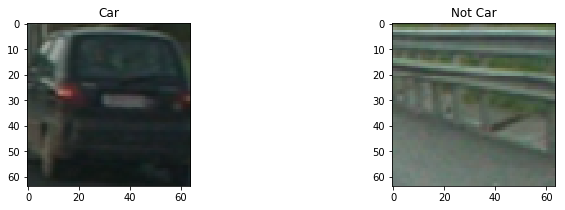

In [5]:
# choose random car and not car images
car_ind = np.random.randint(0, len(vehicles_files))
not_car_ind = np.random.randint(0, len(not_vehicles_files))

car_file = vehicles_files[car_ind]
not_car_file = not_vehicles_files[not_car_ind]

car_img = mpimg.imread(car_file)
not_car_img = mpimg.imread(not_car_file)

visualize([car_img, not_car_img], 1, 2, figsize=(12, 3), titles=['Car', 'Not Car'])

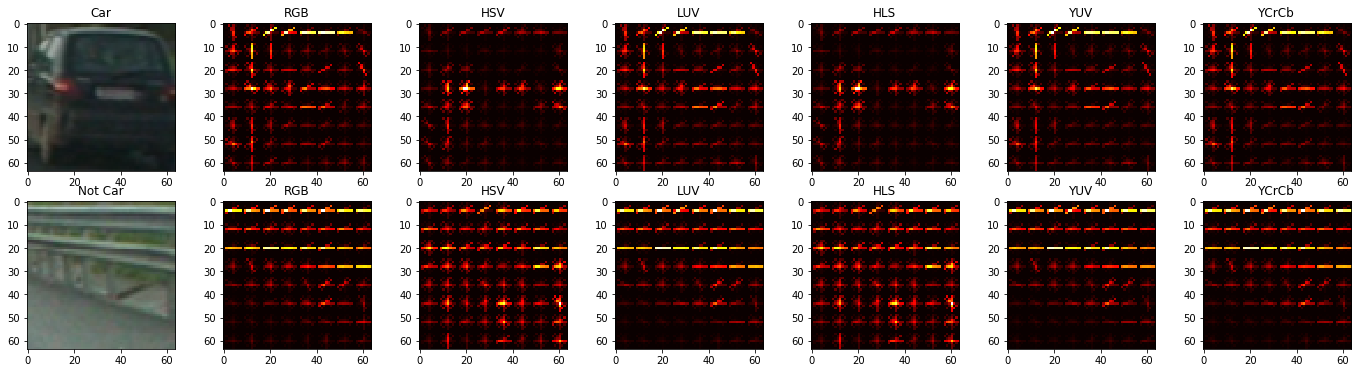

In [6]:
# define features params
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
cs = color_spaces[0]

# color params
spatial_size = (16, 16) # (32, 32)

# histogram params
hist_bins = 16 #32

# HOG params
orient = 6 #9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 #[0, 1, 2, 'ALL']

result_car_hog_images = []
result_not_car_hog_images = []

for cs in color_spaces:
    car_features, car_hog_images = extract_features([car_file], cs, spatial_size, hist_bins, 
                                            orient, pix_per_cell, cell_per_block, hog_channel, 
                                           vis_hog=True)
    result_car_hog_images.extend(car_hog_images)

    not_car_features, not_car_hog_images = extract_features([not_car_file], cs, spatial_size, hist_bins, 
                                            orient, pix_per_cell, cell_per_block, hog_channel, 
                                           vis_hog=True)
    result_not_car_hog_images.extend(not_car_hog_images)

visuliaze_imgs = [car_img]
visuliaze_imgs.extend(result_car_hog_images)
visuliaze_imgs.append(not_car_img)
visuliaze_imgs.extend(result_not_car_hog_images)

titles = ['Car']
titles.extend(color_spaces)
titles.append('Not Car')
titles.extend(color_spaces)

visualize(visuliaze_imgs, 2, 1 + len(color_spaces), figsize=(24,6), titles=titles)

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them). | The HOG features extracted from the training data have been used to train a classifier, could be SVM, Decision Tree or other. Features should be scaled to zero mean and unit variance before training the classifier. |

In [7]:
# define features params
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
cs = color_spaces[5]

# color params
spatial_size = (32, 32)

# histogram params
hist_bins = 32

# HOG params
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' #[0, 1, 2, 'ALL']

num_samples = 1000
cars_idxs = np.random.randint(0, len(vehicles_files), num_samples)
not_cars_idxs = np.random.randint(0, len(not_vehicles_files), num_samples)

start_time = time.time()

test_cars = np.array(vehicles_files)[cars_idxs]
test_not_cars = np.array(not_vehicles_files)[not_cars_idxs]

car_features = extract_features(test_cars, cs, spatial_size, hist_bins, 
                                            orient, pix_per_cell, cell_per_block, hog_channel, 
                                           vis_hog=False)

not_car_features = extract_features(test_not_cars, cs, spatial_size, hist_bins, 
                                            orient, pix_per_cell, cell_per_block, hog_channel, 
                                           vis_hog=False)

spent_time = time.time() - start_time
print('Feature extraction spent time {0:.2f} seconds'.format(spent_time))

X = np.vstack((car_features, not_car_features)).astype(np.float64)

# Normalize data
# fit a per column scaler
X_scaler = StandardScaler().fit(X)
# apply the scaler to X
X_scaled = X_scaler.transform(X)

# define the labels vector y
# 1 - is the label for Car
# 0 - is the label for Not Car
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))


# split the data into train and test sets
# train_test_split splits arrays into random train and test subsets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Train using LinearSVC (Linear Support Vector Classification)
start_time = time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)

spent_time = time.time() - start_time
print('Training spent time {0:.2f} seconds'.format(spent_time))

# check the test accuracy of the model
test_accuracy = svc.score(X_test, y_test)
print('Test Accuracy: {0:.3f}'.format(test_accuracy))


Feature extraction spent time 7.82 seconds
Feature vector length: 8460
Training spent time 1.65 seconds
Test Accuracy: 0.995


In [9]:
# Set the parameters by cross-validation
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()


Best parameters set found on development set:

{'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}

Grid scores on development set:

0.783 (+/-0.142) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1}
0.987 (+/-0.004) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1}
0.804 (+/-0.137) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 10}
0.988 (+/-0.007) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}
0.804 (+/-0.137) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 100}
0.988 (+/-0.007) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 100}
0.804 (+/-0.137) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1000}
0.988 (+/-0.007) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1000}
0.988 (+/-0.006) for {'kernel': 'linear', 'C': 1}
0.988 (+/-0.006) for {'kernel': 'linear', 'C': 10}
0.988 (+/-0.006) for {'kernel': 'linear', 'C': 100}
0.988 (+/-0.006) for {'kernel': 'linear', 'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

            

In [8]:
from features import train

In [9]:
# the best model

# define features params
cs = 'YCrCb'
# color params
spatial_size = (32, 32)
# histogram params
hist_bins = 32
# HOG params
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

classifier, X_scaler = train(vehicles_files, not_vehicles_files,
                   cs, spatial_size, hist_bins,
                   orient, pix_per_cell, cell_per_block, hog_channel)

Feature extraction spent time 75.68 seconds
Feature vector length: 8460
Training spent time 5.14 seconds
Test Accuracy: 0.993


## Sliding Window Search

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows? | A sliding window approach has been implemented, where overlapping tiles in each test image are classified as vehicle or non-vehicle. Some justification has been given for the particular implementation chosen. |

In [810]:
from car_detect import find_windows, find_cars, process_car_candidates

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier? | Some discussion is given around how you improved the reliability of the classifier i.e., fewer false positives and more reliable car detections (this could be things like choice of feature vector, thresholding the decision function, hard negative mining etc.) |

Detected windows number: 192


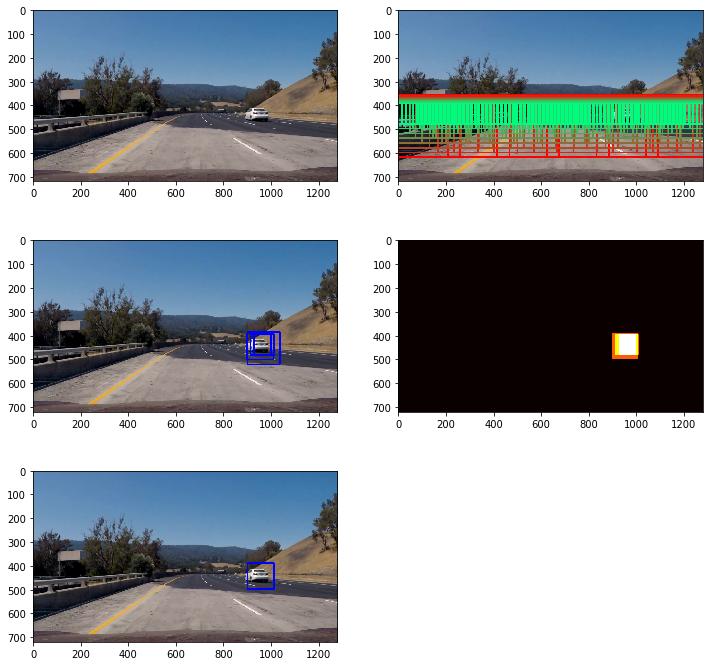

In [821]:
#img = mpimg.imread('./test_images/1/0.jpg')
#img = mpimg.imread('./test_images/1/27.jpg')
img = mpimg.imread('./test_images/608.jpg')
#img = mpimg.imread('./test_images/619.jpg')
#img = mpimg.imread('./test_images/624.jpg')
#img = mpimg.imread('./test_images/625.jpg')
#img = mpimg.imread('./test_images/631.jpg')
#img = mpimg.imread('./test_images/714.jpg')
#img = mpimg.imread('./test_images/745.jpg')
#img = mpimg.imread('./test_images/915.jpg')

svc = classifier

wins_img, wins = find_windows(img)
car_candidates_img, box_list = find_cars(img, wins, svc, X_scaler, cs, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
heatmap, final_img, car_boxes = process_car_candidates(img, box_list, 1)

#plt.imshow(final_img)
visualize([img, wins_img, car_candidates_img, heatmap, final_img], 3, 2, (12,12), titles=None, img_cmap=None)

## Video Implementation

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.) | The sliding-window search plus classifier has been used to search for and identify vehicles in the videos provided. Video output has been generated with detected vehicle positions drawn (bounding boxes, circles, cubes, etc.) on each frame of video. |

In [259]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Detected windows number: 192


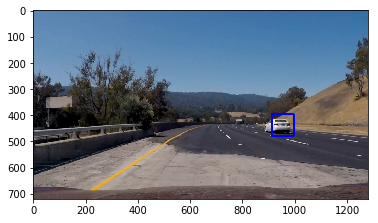

In [845]:
tracker1 = VehicleTracker(classifier, X_scaler,
                 cs, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True, heatmap_threshold=1)

imgs = ['612.jpg', '613.jpg', '614.jpg']

for f in imgs:
    #img = mpimg.imread('./test_images/{0}'.format(f))
    img = mpimg.imread('./test_images/2/{0}'.format(f))
    out_img = tracker1.process_image(img)
#out_img0 = tracker1.process_image(img0)
#out_img = tracker1.process_image(img)
plt.imshow(out_img)

In [823]:
output1 = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")

tracker1 = VehicleTracker(classifier, X_scaler,
                 cs, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heatmap_threshold=1)

out_clip1 = clip1.fl_image(tracker1.process_image)

%time out_clip1.write_videofile(output1, audio=False)

Detected windows number: 192
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:12<00:00,  2.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 13.5 s, sys: 64 ms, total: 13.6 s
Wall time: 13.7 s


In [846]:
output2 = 'project_video_out_notavg.mp4'
clip2 = VideoFileClip("project_video.mp4")

tracker2 = VehicleTracker(classifier, X_scaler,
                 cs, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                          False,
                          heatmap_threshold=1)

out_clip2 = clip2.fl_image(tracker2.process_image)

%time out_clip2.write_videofile(output2, audio=False)

Detected windows number: 192
[MoviePy] >>>> Building video project_video_out_notavg.mp4
[MoviePy] Writing video project_video_out_notavg.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<06:41,  3.14it/s]

  0%|          | 2/1261 [00:00<06:51,  3.06it/s]

  0%|          | 3/1261 [00:00<06:53,  3.04it/s]

  0%|          | 4/1261 [00:01<06:49,  3.07it/s]

  0%|          | 5/1261 [00:01<06:50,  3.06it/s]

  0%|          | 6/1261 [00:01<06:53,  3.03it/s]

  1%|          | 7/1261 [00:02<06:54,  3.03it/s]

  1%|          | 8/1261 [00:02<06:54,  3.02it/s]

  1%|          | 9/1261 [00:02<06:59,  2.98it/s]

  1%|          | 10/1261 [00:03<07:18,  2.85it/s]

  1%|          | 11/1261 [00:03<07:13,  2.88it/s]

  1%|          | 12/1261 [00:04<07:18,  2.85it/s]

  1%|          | 13/1261 [00:04<07:10,  2.90it/s]

  1%|          | 14/1261 [00:04<07:05,  2.93it/s]

  1%|          | 15/1261 [00:05<07:13,  2.87it/s]

  1%|▏         | 16/1261 [00:05<07:17,  2.85it/s]

  1%|▏         | 17/1261 [00:06<08:56,  2.32it/s]

  1%|▏         | 18/1261 [00:06<10:05,  2.05it/s]

  2%|▏         | 19/1261 [00:07<10:51,  1.91it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_notavg.mp4 

CPU times: user 12min 1s, sys: 3.28 s, total: 12min 4s
Wall time: 11min 17s


In [847]:
output3 = 'project_video_out_avg.mp4'
clip3 = VideoFileClip("project_video.mp4")

tracker3 = VehicleTracker(classifier, X_scaler,
                 cs, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                          True,
                          heatmap_threshold=1)

out_clip3 = clip3.fl_image(tracker3.process_image)

%time out_clip3.write_videofile(output3, audio=False)

Detected windows number: 192
[MoviePy] >>>> Building video project_video_out_avg.mp4
[MoviePy] Writing video project_video_out_avg.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<15:50,  1.33it/s]

  0%|          | 2/1261 [00:01<16:02,  1.31it/s]

  0%|          | 3/1261 [00:02<16:13,  1.29it/s]

  0%|          | 4/1261 [00:03<16:24,  1.28it/s]

  0%|          | 5/1261 [00:04<17:02,  1.23it/s]

  0%|          | 6/1261 [00:04<17:34,  1.19it/s]

  1%|          | 7/1261 [00:05<17:58,  1.16it/s]

  1%|          | 8/1261 [00:06<18:03,  1.16it/s]

  1%|          | 9/1261 [00:07<17:46,  1.17it/s]

  1%|          | 10/1261 [00:08<17:03,  1.22it/s]

  1%|          | 11/1261 [00:09<16:37,  1.25it/s]

  1%|          | 12/1261 [00:09<16:14,  1.28it/s]

  1%|          | 13/1261 [00:10<16:01,  1.30it/s]

  1%|          | 14/1261 [00:11<15:52,  1.31it/s]

  1%|          | 15/1261 [00:11<14:54,  1.39it/s]

  1%|▏         | 16/1261 [00:12<14:13,  1.46it/s]

  1%|▏         | 17/1261 [00:13<13:42,  1.51it/s]

  1%|▏         | 18/1261 [00:13<13:24,  1.54it/s]

  2%|▏         | 19/1261 [00:14<13:14,  1.56it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_avg.mp4 

CPU times: user 15min 12s, sys: 4.28 s, total: 15min 16s
Wall time: 14min 16s


| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes. | A method, such as requiring that a detection be found at or near the same position in several subsequent frames, (could be a heat map showing the location of repeat detections) is implemented as a means of rejecting false positives, and this demonstrably reduces the number of false positives. Same or similar method used to draw bounding boxes (or circles, cubes, etc.) around high-confidence detections where multiple overlapping detections occur. |

## Discussion

| **CRITERIA** | **MEETS SPECIFICATIONS** |
|------|------|
| Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust? | Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail. |